In [7]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
import pandas as pd
from deepxde.backend import tf
from scipy import interpolate
print(tf.__version__)

2.7.0


[1.00000e-02 2.10000e-02 3.10000e-02 4.20000e-02 5.20000e-02 6.30000e-02
 7.50000e-02 8.60000e-02 9.80000e-02 1.10000e-01 1.22000e-01 1.34000e-01
 1.47000e-01 1.59000e-01 1.73000e-01 1.86000e-01 1.99000e-01 2.13000e-01
 2.27000e-01 2.42000e-01 2.56000e-01 2.71000e-01 2.86000e-01 3.02000e-01
 3.18000e-01 3.34000e-01 3.50000e-01 3.67000e-01 3.84000e-01 4.02000e-01
 4.19000e-01 4.37000e-01 4.56000e-01 4.74000e-01 4.94000e-01 5.13000e-01
 5.33000e-01 5.53000e-01 5.74000e-01 5.95000e-01 6.16000e-01 6.38000e-01
 6.61000e-01 6.83000e-01 7.06000e-01 7.30000e-01 7.54000e-01 7.79000e-01
 8.04000e-01 8.29000e-01 8.55000e-01 8.81000e-01 9.08000e-01 9.36000e-01
 9.64000e-01 9.92000e-01 1.02200e+00 1.05100e+00 1.08100e+00 1.11200e+00
 1.14400e+00 1.17600e+00 1.20800e+00 1.24200e+00 1.27500e+00 1.31000e+00
 1.34500e+00 1.38100e+00 1.41800e+00 1.45500e+00 1.49300e+00 1.53200e+00
 1.57100e+00 1.61100e+00 1.65300e+00 1.69400e+00 1.73700e+00 1.78000e+00
 1.82500e+00 1.87000e+00 1.91600e+00 1.96300e+00 2.

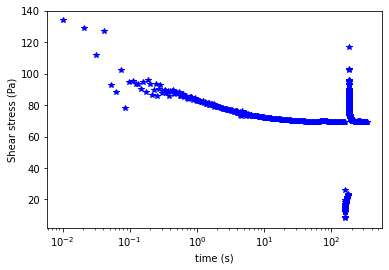

697
697
697
[[ 1.73000000e-01 -2.67512432e-17]
 [ 6.87000000e-01  3.23538928e-05]
 [ 8.78000000e-01  6.17665225e-05]
 ...
 [ 1.00000000e+00  9.77496397e-01]
 [ 1.00000000e+00  9.86152534e-01]
 [ 1.00000000e+00  9.94976323e-01]]


In [6]:
del_stress = 150.0-5.0 
stress_min = 90.0 #114.0
del_time = 340.0-0.01
time_min = 0.01
#del_shear_rate = 10.0-1.9
#shear_min = 1.9 

def gen_training_data():
    
    t_expt = []
    gammadot = []
    shear_stress = []
       
    startUpFlow = pd.read_excel('DOW5622_lowShearRates_101222.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=5) 
    # Reading data from sheet number - itr
    t_expt = np.array(startUpFlow["t"])
    print(t_expt)
    gammadot = np.array(startUpFlow["shear rate"])
    shear_stress = np.array(startUpFlow["shear stress"])

    plt.plot(t_expt,shear_stress,'*b', label='Experiment')
    plt.xscale('log')
    plt.xlabel('time (s)')
    plt.ylabel('Shear stress (Pa)')
    plt.show()
        
    # Non-Dimensionalizing - O(0-1)
    t_expt =  (t_expt-time_min)/(del_time)  
    #gammadot_itr =  (gammadot_itr-shear_min)/(del_shear_rate)          
    shear_stress = (shear_stress-stress_min)/(del_stress) 
    
    # Converting to a column
    t_expt = t_expt[:,np.newaxis]
    gammadot = gammadot[:,np.newaxis]
    shear_stress = shear_stress[:,np.newaxis]
    
    print(np.size(t_expt))
    print(np.size(gammadot))   
    print(np.size(shear_stress))
    
    return np.hstack((gammadot, t_expt)) , shear_stress
    

#observe_x, shear_stress_training = gen_training_data()
#print(observe_x)

In [24]:
del_stress = 150.0-5.0 
stress_min = 90.0 #114.0
del_time = 340.0-0.01
time_min = 0.01
#del_shear_rate = 10.0-1.9
#shear_min = 1.9 

# time interval and shear interval of interest
timedomain = dde.geometry.TimeDomain(0,1) # non-dimensional end time
geom = dde.geometry.Interval(0,1) # non-dimensional shear rate
timexgeom = dde.geometry.GeometryXTime(geom, timedomain) # this is why geom is x[:,0:1] and time is x[:,1:2]?

# From inverse problem
G = 202.0
eta_s = 39.5
k_plus = 0.044
k_minus = 0.063

# From experiments
yield_stress = 29.5 # Extrapolation to zero shear rate
eta_p = 42.0 # Viscosity at 20/s - material totally fluidized

# defining the TEVP rheology model
def pde(x,y):
    
    stress, struct_param = y[:,0:1], y[:,1:2]
    shear_rate, t = x[:,0:1], x[:,1:2]
    
    stress_rate = dde.grad.jacobian(y,x,i=0,j=1)
    struct_rate = dde.grad.jacobian(y,x,i=1,j=1)
    
    eqn1 = stress_rate - (G*del_time)/((eta_s+eta_p)*del_stress)* \
           (-stress*del_stress - stress_min + yield_stress*struct_param \
            + (eta_s + eta_p*struct_param)*(shear_rate)) # removed exponent n 
    
    eqn2 = struct_rate - del_time*(k_plus*(1-struct_param) - k_minus*struct_param*(shear_rate))
                                  
    return [eqn1,eqn2]


# Initial condition
# ic_struct_param = dde.IC(timexgeom, lambda X: 1, lambda _,on_initial: on_initial, component=1) # Assigning lambda=1 at t=0


# defining the data 
data = dde.data.TimePDE(
    timexgeom,
    pde,
    [], 
    num_domain = 3000, 
    # anchors = observe_x,
    num_test = 5000, 
    #num_initial = 200,
    train_distribution='pseudo', 
)

In [25]:
layer_size = [2] + [50]*6 + [2] # layer size dimensions [80]*4
activation = "tanh" 
initializer = "Glorot normal" # Xavier initialization

# developing the Neural network
net = dde.nn.FNN(layer_size, activation, initializer)

#def output_transform(x,y):
#    return tf.concat((y[:,0:1], tf.sigmoid(y[:,1:2])), axis=1)
    #return tf.sigmoid(y[:,1:2])

net.apply_output_transform(output_transform)

# developing the model
model = dde.Model(data,net)



In [26]:
# compiling the NN
model.compile("adam",
              lr=0.001, 
              loss_weights=[1,1])


Compiling model...
Building feed-forward neural network...


C:\ProgramData\Anaconda3\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
C:\ProgramData\Anaconda3\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'build' took 0.498960 s

'compile' took 3.905994 s



Initializing variables...
Training model...

0         [2.22e+05, 1.55e+01]    [2.24e+05, 1.56e+01]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1000      [1.27e+00, 1.29e+01]    [1.27e+00, 1.31e+01]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
2000      [8.56e-01, 8.95e+00]    [8.50e-01, 9.09e+00]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-2000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
3000      [8.66e-01, 7.05e+00]    [8.47e-01, 7.15e+00]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-3000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
4000      [8.73e-01, 5.82e+00]    [8.48e-01, 5.90e+00]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC562

61000     [5.69e-02, 2.70e-01]    [5.40e-02, 2.65e-01]    []  
62000     [2.25e-02, 2.11e-01]    [2.12e-02, 2.05e-01]    []  
63000     [7.40e-03, 1.99e-01]    [7.10e-03, 1.92e-01]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-63000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
64000     [5.12e-03, 1.93e-01]    [4.81e-03, 1.87e-01]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-64000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
65000     [1.07e-02, 1.80e-01]    [1.09e-02, 1.74e-01]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-65000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
66000     [1.65e-01, 1.83e-01]    [1.63e-01, 1.77e-01]    []  
67000     [7.69e+00, 4.74e-01]    [7.60e+00, 4.65e-01]    []  
68000     [8.42e-02, 2.46e-01]    [8.01e-02, 2.41e-01]    []  
69000     [2.36e-02, 1.96e-01]    [2.22e-02, 1.90e-01]    

INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-132000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
133000    [2.85e-03, 2.62e-02]    [2.54e-03, 2.46e-02]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-133000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
134000    [2.89e-03, 2.54e-02]    [2.55e-03, 2.38e-02]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-134000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
135000    [5.09e-01, 2.93e-02]    [5.12e-01, 2.74e-02]    []  
136000    [2.56e-02, 2.57e-02]    [2.61e-02, 2.40e-02]    []  
137000    [1.79e-02, 2.45e-02]    [1.77e-02, 2.29e-02]    []  
138000    [1.35e+00, 2.40e-02]    [1.37e+00, 2.25e-02]    []  
139000    [7.13e-01, 2.87e-01]    [6.74e-01, 2.84e-01]    []  
140000    [3.58e-03, 2.78e-02]    [3.37e-03, 2.60e-02]    []  
141000    [2.77e-03, 2.46e-02]    [2.56e-03, 2.31e-02] 

229000    [3.88e-01, 1.77e-02]    [3.88e-01, 1.63e-02]    []  
230000    [1.49e-01, 1.58e-02]    [1.49e-01, 1.45e-02]    []  
231000    [4.93e-03, 1.52e-02]    [4.46e-03, 1.40e-02]    []  
232000    [5.76e-03, 1.50e-02]    [5.55e-03, 1.37e-02]    []  
233000    [5.25e-03, 1.63e-02]    [5.17e-03, 1.48e-02]    []  
234000    [1.92e-03, 1.67e-02]    [1.59e-03, 1.52e-02]    []  
235000    [6.86e-03, 1.45e-02]    [6.71e-03, 1.33e-02]    []  
236000    [1.75e-03, 1.41e-02]    [1.59e-03, 1.29e-02]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-236000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
237000    [1.59e-01, 1.46e-02]    [1.61e-01, 1.35e-02]    []  
238000    [2.37e-03, 1.46e-02]    [2.11e-03, 1.34e-02]    []  
239000    [1.38e-02, 1.44e-02]    [1.32e-02, 1.32e-02]    []  
240000    [2.51e-02, 1.46e-02]    [2.60e-02, 1.33e-02]    []  
241000    [2.01e-03, 1.53e-02]    [1.77e-03, 1.40e-02]    []  
242000    [4.05e-01, 1.66e-02]    

344000    [2.13e-03, 1.06e-02]    [2.01e-03, 9.57e-03]    []  
345000    [8.30e-03, 1.07e-02]    [8.09e-03, 9.60e-03]    []  
346000    [7.98e-02, 1.09e-02]    [7.82e-02, 9.81e-03]    []  
347000    [6.15e-01, 1.11e-02]    [6.19e-01, 9.98e-03]    []  
348000    [8.34e-02, 1.54e-01]    [7.78e-02, 1.53e-01]    []  
349000    [1.58e-03, 1.12e-02]    [1.43e-03, 1.01e-02]    []  
350000    [2.82e-03, 1.10e-02]    [2.86e-03, 9.89e-03]    []  
351000    [3.89e-03, 1.05e-02]    [3.70e-03, 9.44e-03]    []  
352000    [2.80e-01, 1.07e-02]    [2.82e-01, 9.61e-03]    []  
353000    [5.65e-03, 1.07e-02]    [5.27e-03, 9.59e-03]    []  
354000    [5.63e-01, 1.22e-02]    [5.55e-01, 1.11e-02]    []  
355000    [9.96e-02, 2.51e-01]    [8.88e-02, 2.49e-01]    []  
356000    [6.16e-03, 1.54e-02]    [5.33e-03, 1.43e-02]    []  
357000    [2.89e-03, 1.34e-02]    [2.57e-03, 1.24e-02]    []  
358000    [6.25e-03, 1.21e-02]    [5.90e-03, 1.10e-02]    []  
359000    [2.11e-03, 1.16e-02]    [1.92e-03, 1.06e-02] 

470000    [2.09e-02, 1.02e-02]    [2.03e-02, 9.18e-03]    []  
471000    [2.18e-03, 9.81e-03]    [2.07e-03, 8.86e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-471000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
472000    [2.42e-03, 9.82e-03]    [2.40e-03, 8.87e-03]    []  
473000    [2.11e-01, 9.93e-03]    [2.13e-01, 8.95e-03]    []  
474000    [1.37e-02, 1.03e-02]    [1.38e-02, 9.26e-03]    []  
475000    [9.08e-03, 9.79e-03]    [8.49e-03, 8.82e-03]    []  
476000    [2.11e-03, 9.80e-03]    [2.09e-03, 8.79e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-476000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
477000    [7.79e-03, 2.86e-02]    [7.47e-03, 2.67e-02]    []  
478000    [1.50e-03, 1.10e-02]    [1.42e-03, 9.95e-03]    []  
479000    [1.88e-03, 1.02e-02]    [1.66e-03, 9.20e-03]    []  
480000    [2.25e-02, 9.92e-03]    [2.14e-02, 8.91e-03]    []  
481000    [8.

587000    [2.22e-01, 9.08e-03]    [2.22e-01, 7.99e-03]    []  
588000    [3.93e-01, 8.69e-03]    [4.02e-01, 7.72e-03]    []  
589000    [3.08e-02, 8.46e-03]    [2.93e-02, 7.44e-03]    []  
590000    [7.49e+00, 4.03e-01]    [7.33e+00, 4.01e-01]    []  
591000    [4.86e-02, 1.14e-02]    [4.66e-02, 1.02e-02]    []  
592000    [3.15e-02, 1.00e-02]    [3.16e-02, 8.91e-03]    []  
593000    [2.74e-01, 9.37e-03]    [2.79e-01, 8.29e-03]    []  
594000    [4.21e-01, 8.98e-03]    [4.27e-01, 7.92e-03]    []  
595000    [2.30e-03, 8.18e-03]    [2.03e-03, 7.15e-03]    []  
596000    [4.39e-02, 7.96e-03]    [4.29e-02, 6.95e-03]    []  
597000    [4.77e-03, 1.62e-02]    [4.56e-03, 1.47e-02]    []  
598000    [3.85e-03, 1.05e-02]    [3.69e-03, 9.36e-03]    []  
599000    [8.56e-03, 9.22e-03]    [8.24e-03, 8.14e-03]    []  
600000    [2.62e-03, 8.49e-03]    [2.50e-03, 7.48e-03]    []  
601000    [2.31e-03, 8.13e-03]    [2.16e-03, 7.12e-03]    []  
602000    [1.91e-01, 8.02e-03]    [1.94e-01, 7.04e-03] 

687000    [1.82e-03, 3.27e-03]    [1.87e-03, 2.49e-03]    []  
688000    [1.77e-03, 3.31e-03]    [1.56e-03, 2.52e-03]    []  
689000    [1.31e-02, 3.27e-03]    [1.35e-02, 2.48e-03]    []  
690000    [7.70e-04, 3.51e-03]    [6.28e-04, 2.69e-03]    []  
691000    [3.07e-01, 3.32e-03]    [3.08e-01, 2.53e-03]    []  
692000    [9.34e-02, 3.12e-03]    [9.57e-02, 2.35e-03]    []  
693000    [1.36e-03, 3.12e-03]    [1.08e-03, 2.35e-03]    []  
694000    [5.63e-03, 3.01e-03]    [5.82e-03, 2.26e-03]    []  
695000    [1.21e-02, 2.97e-03]    [1.26e-02, 2.22e-03]    []  
696000    [8.18e-04, 3.61e-03]    [6.67e-04, 2.79e-03]    []  
697000    [5.61e-04, 3.13e-03]    [4.84e-04, 2.35e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-697000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
698000    [5.96e-02, 3.31e-03]    [6.04e-02, 2.53e-03]    []  
699000    [7.64e-03, 3.57e-03]    [7.27e-03, 2.80e-03]    []  
700000    [3.92e-02, 3.03e-03]    

799000    [1.33e-02, 2.67e-03]    [1.34e-02, 1.90e-03]    []  
800000    [6.23e-03, 2.57e-03]    [6.23e-03, 1.81e-03]    []  
801000    [3.77e-04, 2.88e-03]    [3.87e-04, 2.09e-03]    []  
802000    [2.29e-04, 2.76e-03]    [2.29e-04, 1.97e-03]    []  
803000    [2.89e-04, 2.64e-03]    [2.93e-04, 1.87e-03]    []  
804000    [1.27e-03, 3.34e-03]    [1.25e-03, 2.55e-03]    []  
805000    [2.98e-03, 2.64e-03]    [2.96e-03, 1.87e-03]    []  
806000    [7.70e-03, 2.71e-03]    [7.59e-03, 1.95e-03]    []  
807000    [7.97e-02, 2.84e-03]    [7.91e-02, 2.07e-03]    []  
808000    [3.17e-04, 2.61e-03]    [3.21e-04, 1.85e-03]    []  
809000    [1.83e-02, 2.68e-03]    [1.79e-02, 1.90e-03]    []  
810000    [3.16e-04, 2.53e-03]    [3.26e-04, 1.77e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-810000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
811000    [6.20e-02, 2.55e-03]    [6.28e-02, 1.79e-03]    []  
812000    [3.27e-04, 3.22e-03]    

923000    [2.26e-04, 2.61e-03]    [2.29e-04, 1.82e-03]    []  
924000    [2.40e-03, 2.57e-03]    [2.37e-03, 1.79e-03]    []  
925000    [1.62e-03, 2.58e-03]    [1.60e-03, 1.79e-03]    []  
926000    [2.50e-04, 2.56e-03]    [2.56e-04, 1.77e-03]    []  
927000    [2.04e-04, 2.60e-03]    [2.10e-04, 1.79e-03]    []  
928000    [1.72e-02, 2.79e-03]    [1.73e-02, 2.00e-03]    []  
929000    [1.33e-02, 2.50e-03]    [1.32e-02, 1.72e-03]    []  
930000    [5.09e-04, 3.00e-03]    [4.84e-04, 2.18e-03]    []  
931000    [2.15e-02, 2.79e-03]    [2.16e-02, 2.01e-03]    []  
932000    [1.82e-01, 2.81e-03]    [1.85e-01, 2.03e-03]    []  
933000    [4.93e-02, 2.55e-03]    [4.82e-02, 1.78e-03]    []  
934000    [1.35e-02, 2.50e-03]    [1.34e-02, 1.72e-03]    []  
935000    [9.64e-03, 2.43e-03]    [9.77e-03, 1.66e-03]    []  
936000    [3.52e-03, 2.43e-03]    [3.45e-03, 1.65e-03]    []  
937000    [1.77e-04, 2.39e-03]    [1.86e-04, 1.62e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-step-strain/model-

1047000   [1.04e-03, 4.81e-03]    [9.20e-04, 3.95e-03]    []  
1048000   [2.10e-04, 2.43e-03]    [2.15e-04, 1.65e-03]    []  
1049000   [4.54e-04, 2.21e-03]    [4.62e-04, 1.45e-03]    []  
1050000   [1.04e-02, 2.16e-03]    [1.05e-02, 1.40e-03]    []  
1051000   [5.32e-02, 2.22e-03]    [5.31e-02, 1.46e-03]    []  
1052000   [1.53e-03, 2.10e-03]    [1.52e-03, 1.35e-03]    []  
1053000   [1.42e-03, 4.99e-03]    [1.35e-03, 4.14e-03]    []  
1054000   [1.60e-01, 2.70e-03]    [1.60e-01, 1.93e-03]    []  
1055000   [2.46e-04, 2.34e-03]    [2.48e-04, 1.56e-03]    []  
1056000   [4.45e-02, 2.54e-03]    [4.45e-02, 1.75e-03]    []  
1057000   [1.69e-04, 2.27e-03]    [1.72e-04, 1.48e-03]    []  
1058000   [3.06e-04, 2.24e-03]    [3.08e-04, 1.46e-03]    []  
1059000   [1.41e-02, 2.22e-03]    [1.41e-02, 1.44e-03]    []  
1060000   [1.39e-01, 3.42e-02]    [1.36e-01, 3.30e-02]    []  
1061000   [2.38e-04, 2.32e-03]    [2.38e-04, 1.54e-03]    []  
1062000   [2.69e-04, 2.28e-03]    [2.72e-04, 1.50e-03] 

1170000   [5.67e-03, 2.36e-03]    [5.64e-03, 1.52e-03]    []  
1171000   [2.11e-03, 2.30e-03]    [2.09e-03, 1.48e-03]    []  
1172000   [7.09e-02, 2.65e-03]    [6.98e-02, 1.82e-03]    []  
1173000   [1.66e-03, 2.20e-03]    [1.66e-03, 1.40e-03]    []  
1174000   [1.88e-04, 2.19e-03]    [1.95e-04, 1.40e-03]    []  
1175000   [5.76e-02, 2.24e-03]    [5.78e-02, 1.45e-03]    []  
1176000   [2.62e-02, 2.29e-03]    [2.59e-02, 1.50e-03]    []  
1177000   [2.01e-04, 2.20e-03]    [2.10e-04, 1.41e-03]    []  
1178000   [1.99e-02, 2.13e-03]    [2.02e-02, 1.35e-03]    []  
1179000   [4.65e-02, 2.12e-03]    [4.60e-02, 1.35e-03]    []  
1180000   [1.94e-04, 2.34e-03]    [2.02e-04, 1.54e-03]    []  
1181000   [1.68e-04, 2.17e-03]    [1.77e-04, 1.39e-03]    []  
1182000   [1.61e-03, 2.19e-03]    [1.60e-03, 1.40e-03]    []  
1183000   [1.52e-03, 2.13e-03]    [1.52e-03, 1.35e-03]    []  
1184000   [9.12e-04, 2.09e-03]    [9.04e-04, 1.31e-03]    []  
1185000   [5.88e-03, 2.08e-03]    [5.97e-03, 1.31e-03] 

1301000   [5.48e-02, 2.34e-03]    [5.45e-02, 1.59e-03]    []  
1302000   [4.34e-03, 2.07e-03]    [4.36e-03, 1.31e-03]    []  
1303000   [3.63e-02, 2.02e-03]    [3.62e-02, 1.26e-03]    []  
1304000   [1.37e-02, 1.96e-03]    [1.39e-02, 1.21e-03]    []  
1305000   [9.56e-04, 7.08e-03]    [8.71e-04, 6.26e-03]    []  
1306000   [2.32e-04, 2.36e-03]    [2.45e-04, 1.58e-03]    []  
1307000   [1.88e-04, 2.20e-03]    [1.94e-04, 1.42e-03]    []  
1308000   [2.24e-04, 2.14e-03]    [2.28e-04, 1.36e-03]    []  
1309000   [1.37e-01, 2.48e-03]    [1.37e-01, 1.71e-03]    []  
1310000   [5.64e-02, 2.10e-03]    [5.61e-02, 1.32e-03]    []  
1311000   [2.31e-02, 2.04e-03]    [2.28e-02, 1.26e-03]    []  
1312000   [2.65e-02, 2.11e-03]    [2.66e-02, 1.34e-03]    []  
1313000   [4.66e-03, 1.98e-03]    [4.71e-03, 1.22e-03]    []  
1314000   [3.76e-02, 2.22e-03]    [3.69e-02, 1.47e-03]    []  
1315000   [5.72e-04, 2.50e-03]    [5.46e-04, 1.70e-03]    []  
1316000   [3.34e-04, 2.14e-03]    [3.36e-04, 1.39e-03] 

1422000   [1.81e-04, 2.16e-03]    [1.87e-04, 1.36e-03]    []  
1423000   [1.27e-03, 2.05e-03]    [1.27e-03, 1.28e-03]    []  
1424000   [1.70e-04, 2.00e-03]    [1.71e-04, 1.23e-03]    []  
1425000   [4.03e-03, 1.97e-03]    [4.00e-03, 1.22e-03]    []  
1426000   [2.20e-02, 1.94e-03]    [2.20e-02, 1.19e-03]    []  
1427000   [1.02e-02, 1.93e-03]    [1.03e-02, 1.19e-03]    []  
1428000   [2.42e-04, 2.03e-03]    [2.38e-04, 1.28e-03]    []  
1429000   [1.43e-01, 2.28e-03]    [1.43e-01, 1.53e-03]    []  
1430000   [2.66e-03, 1.97e-03]    [2.68e-03, 1.22e-03]    []  
1431000   [4.88e-02, 2.24e-03]    [4.94e-02, 1.48e-03]    []  
1432000   [2.26e-02, 1.96e-03]    [2.23e-02, 1.20e-03]    []  
1433000   [5.67e-02, 1.97e-03]    [5.74e-02, 1.22e-03]    []  
1434000   [2.21e-04, 1.96e-03]    [2.29e-04, 1.23e-03]    []  
1435000   [1.93e-04, 1.92e-03]    [1.96e-04, 1.18e-03]    []  
1436000   [5.35e-02, 2.03e-03]    [5.25e-02, 1.27e-03]    []  
1437000   [1.34e-02, 1.95e-03]    [1.32e-02, 1.20e-03] 

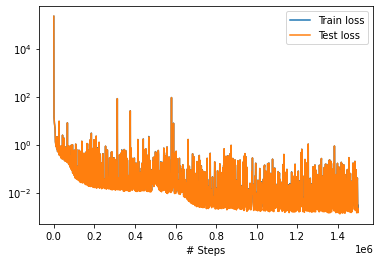

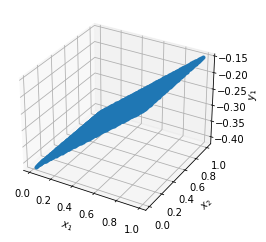

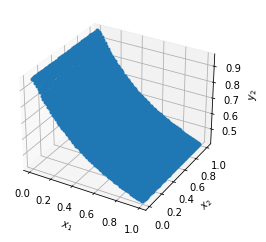

In [27]:

# saving model at intermediate steps
checkpointer = dde.callbacks.ModelCheckpoint(
     "model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1", verbose=0, save_better_only=True
 )

# Resampling PDE loss data pointsii
#resampler = dde.callbacks.PDEResidualResampler(period=1000)

#training the model 
losshistory, trainstate = model.train(epochs = 1500000, callbacks = [checkpointer],model_save_path='C/model-DOWTC5622-TEVP-step-strain') 


dde.saveplot(losshistory, trainstate, issave=True, isplot=True)



In [22]:
# experimental data to validate the model results (sheet name corresponds to shear rate value from expt) #

del_stress = 150.0-5.0 
stress_min = 90.0 #114.0
del_time = 340.0-0.01
time_min = 0.01
#del_shear_rate = 10.0-1.9
#shear_min = 1.9 

valPoints = pd.read_excel('DOW5622_lowShearRates_101222.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=5)

t_expt1 = np.array(valPoints["t"])
t_expt1 = t_expt1[:,np.newaxis] # Converting to a column vector
#print(t_expt1)
gammadot1 = np.array(valPoints["shear rate"])
gammadot1 = gammadot1[:,np.newaxis]
#print(gammadot1)
shear_stress1 = np.array(valPoints["shear stress"])
shear_stress1 = shear_stress1[:,np.newaxis] # experiment value
#print(shear_stress1)

t_non_dim =  (t_expt1-time_min)/(del_time) #(t_expt1-0.5)/(600.0-0.5)              

# using model to predict shear stress at a new shear rate #

test_data_set = np.hstack((gammadot1,t_non_dim))
test_shear_stress = model.predict(test_data_set,operator=lambda x,y: y[:,0:1]) # only predicting the shear stress and not struct param
test_struct_param = model.predict(test_data_set,operator=lambda x,y: y[:,1:2])
# making non-dimensional to dimensional
test_shear_stress = test_shear_stress*(del_stress) + stress_min

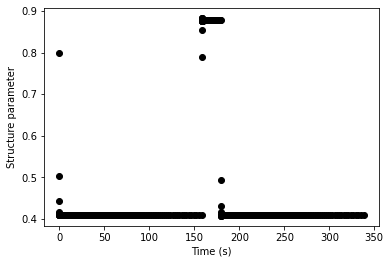

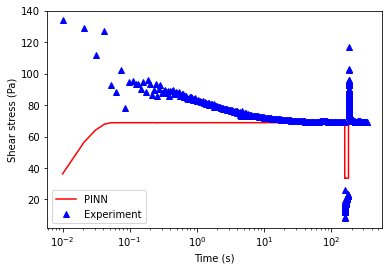

In [23]:
# plotting
plt.figure()
plt.plot(t_expt1,test_struct_param, 'ok', label='PINN-Structure-Parameter')
plt.title('')
plt.xlabel('Time (s)')
plt.ylabel('Structure parameter')
plt.savefig('Structure_Paramater_7s.pdf')
plt.show()


plt.figure()
plt.plot(t_expt1,test_shear_stress, '-r', label='PINN')
plt.plot(t_expt1,shear_stress1, '^b', label='Experiment')
plt.legend()
plt.xscale('log')
#plt.title('8/s - prediction')
plt.xlabel('Time (s)')
plt.ylabel('Shear stress (Pa)')
plt.savefig('Shear_stress_7s.pdf')
plt.show()


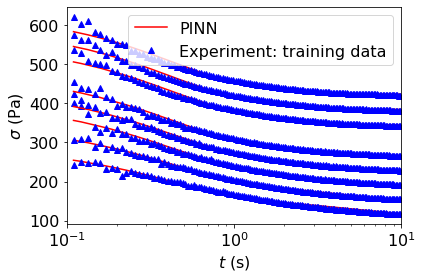

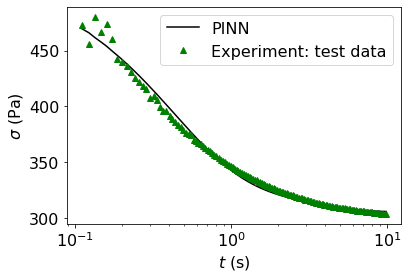

In [23]:
# Plotting #
plt.rcParams.update({'font.size': 16})

for itrnew in range(1,10):
    if itrnew == 6:
        continue
    valPoints = pd.read_excel('DOWTC5622-09-02-22.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=itrnew,skiprows=range(148,296))
    
    t_expt1 = np.array(valPoints["t"])
    t_expt1 = t_expt1[:,np.newaxis] # Converting to a column vector

    gammadot1 = np.array(valPoints["shear rate"])
    gammadot1 = gammadot1[:,np.newaxis]

    shear_stress1 = np.array(valPoints["shear stress"])
    shear_stress1 = shear_stress1[:,np.newaxis] # experiment value


    t_non_dim =  (t_expt1-time_min)/(del_time) #(t_expt1-0.5)/(600.0-0.5)
    gammadot_non_dim = (gammadot1-shear_min)/(del_shear_rate) # (gammadot1-0.1)/(20.0-0.1)               

    # using model to predict shear stress at a new shear rate #

    test_data_set = np.hstack((gammadot_non_dim,t_non_dim))

    test_shear_stress = model.predict(test_data_set,operator=lambda x,y: y[:,0:1]) # only predicting the shear stress and not struct param
    #test_struct_param = model.predict(test_data_set,operator=lambda x,y: y[:,1:2])
    # making non-dimensional to dimensional
    test_shear_stress = test_shear_stress*(del_stress) + stress_min
    
    
    #plt.figure()
    if itrnew == 1:
        plt.plot(t_expt1,test_shear_stress, '-r', label='PINN')
        plt.plot(t_expt1,shear_stress1, '^b', label='Experiment: training data')
    elif itrnew == 6:
        plt.plot(t_expt1,test_shear_stress, '-k', label='PINN: prediction '+str(itrnew+1)+'/s')
        plt.plot(t_expt1,shear_stress1, '^g', label='Experiment: test data '+str(itrnew+1)+'/s')
    else:
        plt.plot(t_expt1,test_shear_stress, '-r')
        plt.plot(t_expt1,shear_stress1, '^b')

plt.xlim([0.1, 10])
plt.legend(loc='upper right')
plt.xscale('log')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.savefig('Shear_stress_trainingdata_DOW5622.jpg',bbox_inches='tight')
plt.show()

valPoints = pd.read_excel('DOWTC5622-09-02-22.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=6,skiprows=range(148,296))
    
t_expt1 = np.array(valPoints["t"])
t_expt1 = t_expt1[:,np.newaxis] # Converting to a column vector

gammadot1 = np.array(valPoints["shear rate"])
gammadot1 = gammadot1[:,np.newaxis]

shear_stress1 = np.array(valPoints["shear stress"])
shear_stress1 = shear_stress1[:,np.newaxis] # experiment value


t_non_dim =  (t_expt1-time_min)/(del_time) #(t_expt1-0.5)/(600.0-0.5)
gammadot_non_dim = (gammadot1-shear_min)/(del_shear_rate) # (gammadot1-0.1)/(20.0-0.1)               

    # using model to predict shear stress at a new shear rate #

test_data_set = np.hstack((gammadot_non_dim,t_non_dim))
test_shear_stress = model.predict(test_data_set,operator=lambda x,y: y[:,0:1]) # only predicting the shear stress and not struct param
test_shear_stress = test_shear_stress*(del_stress) + stress_min

plt.plot(t_expt1,test_shear_stress, '-k', label='PINN')
plt.plot(t_expt1,shear_stress1, '^g', label='Experiment: test data')
    
# plt.figure()
#plt.xlim([0.1, 10])
plt.legend(loc='upper right')
plt.xscale('log')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.savefig('Shear_stress_testdata_DOW5622_7s.jpg',bbox_inches='tight')
plt.show()

In [10]:
# Restore the saved model with the smallest training loss - Run initial steps until compilation
# enter the correct model number
model.restore(f"model-DOWTC5622-TEVP-step-strain/model-DOWTC5622-TEVP-final1-1500000.ckpt", verbose=1)


Restoring model from model-DOWTC5622-TEVP-final1-7s/model-DOWTC5622-TEVP-final1-1500000.ckpt ...

INFO:tensorflow:Restoring parameters from model-DOWTC5622-TEVP-final1-7s/model-DOWTC5622-TEVP-final1-1500000.ckpt


In [ ]:
# Solving forward problem to predict step-strain flow protocol 


Compiling model...
'compile' took 0.507090 s

Training model...

1500091   [2.03e-06, 2.45e-06, 2.48e-04]    [2.54e-06, 2.18e-06, 2.48e-04]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000252
  Number of iterations: 1
  Number of functions evaluations: 18
1500109   [2.03e-06, 2.45e-06, 2.48e-04]    [2.54e-06, 2.18e-06, 2.48e-04]    []  

Best model at step 1500091:
  train loss: 2.52e-04
  test loss: 2.52e-04
  test metric: []

'train' took 1.818854 s

Saving loss history to C:\Users\pnagrani\loss.dat ...
Saving training data to C:\Users\pnagrani\train.dat ...
Saving test data to C:\Users\pnagrani\test.dat ...


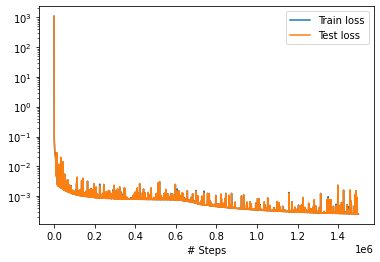

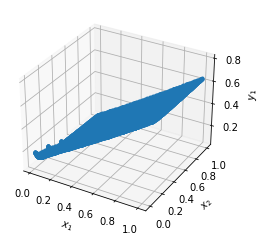

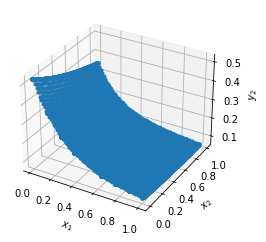

Compiling model...
'compile' took 0.630434 s

Training model...

Step      Train loss                        Test loss                         Test metric
1500109   [2.03e-06, 2.45e-06, 2.48e-05]    [2.54e-06, 2.18e-06, 2.48e-05]    []  

Best model at step 1500109:
  train loss: 2.93e-05
  test loss: 2.95e-05
  test metric: []

'train' took 0.628264 s



In [37]:
# dde.config.real.set_float64()

model.compile("L-BFGS-B",
              loss_weights=[1,1,1e1],
              external_trainable_variables=[G, eta_s, k_plus, k_minus])

model.train_step.optimizer_kwargs = {'options': {'maxfun': 1e5, 'ftol': 1e-20, 'gtol': 1e-20,'eps': 1e-20, 'iprint': -1, 'maxiter': 1e5}}

variable = dde.callbacks.VariableValue([G, eta_s, k_plus, k_minus], period=10, filename="variables1-4s_DOWTC5622_LBFGSB.dat")
losshistory, trainstate = model.train(callbacks = [variable])
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)

variable = dde.callbacks.VariableValue([G, eta_s, k_plus, k_minus], period=1, filename="dummy-4s.txt")
model.compile("adam", lr=0, external_trainable_variables=[G, eta_s, k_plus, k_minus])
losshistory2, train_state2 = model.train(epochs=0, callbacks=[variable], display_every=1)

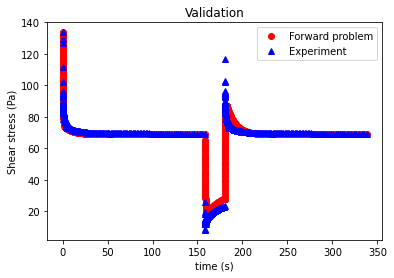

In [47]:
### Solving direct problem based on odeint ###

from scipy.integrate import odeint

valPoints1 = pd.read_excel('DOW5622_lowShearRates_101222.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=5)
t_expt2 = np.array(valPoints1["t"])
t_expt2 = t_expt2[:,np.newaxis] # Converting to a column vector
#print(np.size(t_expt2))
gammadot2 = np.array(valPoints1["shear rate"])
gammadot2 = gammadot2[:,np.newaxis]
#print(np.size(gammadot2))
shear_stress2 = np.array(valPoints1["shear stress"])
shear_stress2 = shear_stress2[:,np.newaxis] # experiment value
#print(np.size(shear_stress2))

def dydt(y,t,G,eta_s,eta_p,k_plus,k_minus,yield_stress):
    
    shear_rate_ode = (1-np.heaviside(t-158.25,1))*1.0 + (np.heaviside(t-158.25,1)-np.heaviside(t-180.117,1))*0.1 \
    + (np.heaviside(t-180.117,1)-np.heaviside(t-338.292,1))*1.0
    
    y1, y2 = y
    dydt = [(G/(eta_s+eta_p))*(-y1 + yield_stress*y2 + (eta_s + eta_p*y2)*shear_rate_ode), k_plus*(1-y2) - k_minus*y2*shear_rate_ode]
    return dydt

t = t_expt2.reshape(np.size(t_expt2),) #Non-dimensional time
y0 = [133.79,0.5] 

# shear_rate_ode = 5
G_ode = 202.0
eta_s_ode = 39.5
eta_p_ode = 42.0
k_plus_ode = 0.044
k_minus_ode = 0.063
yield_stress_ode = 29.5


stress_ode = odeint(dydt,y0,t,args=(G_ode,eta_s_ode,eta_p_ode,k_plus_ode,k_minus_ode,yield_stress_ode))

#print(np.size(stress_ode))
#print(stress_ode)
plt.plot(t_expt2,stress_ode[:,0], 'or', label='Forward problem') 
plt.plot(t_expt2,shear_stress2, '^b', label='Experiment')
plt.legend()
#plt.xscale('log')
plt.title('Validation')
plt.xlabel('time (s)')
plt.ylabel('Shear stress (Pa)')
plt.show()

In [55]:
# experimental data to validate the model results (sheet name corresponds to shear rate value from expt) #

# Predict unknown start up flow and step strain?

valPoints = pd.read_excel('DOWTC5622-07-19-22.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=3, skiprows=range(171,346))

t_expt_dp = np.array(valPoints["t"])
t_expt_dp = t_expt_dp[:,np.newaxis] # Converting to a column vector
#print(t_expt1)
gammadot_dp = np.array(valPoints["shear rate"])
gammadot_dp = gammadot_dp[:,np.newaxis]
#print(gammadot1)
shear_stress_dp = np.array(valPoints["shear stress"])
shear_stress_dp = shear_stress_dp[:,np.newaxis] # experiment value
#print(shear_stress1)

# Non-dimensionalizing for input to direct problem
t_non_dim =  (t_expt_dp-t_expt_dp[0])/(del_time)
gammadot_non_dim = (gammadot_dp-shear_min)/del_shear_rate              

# using model to predict shear stress at a new shear rate #

test_data_set = np.hstack((gammadot_non_dim,t_non_dim))
#print(test_data_set)

test_shear_stress_dp = model.predict(test_data_set,operator=lambda x,y: y[:,0:1]) # only predicting the shear stress and not struct param
test_struct_param = model.predict(test_data_set,operator=lambda x,y: y[:,1:2])
# making non-dimensional to dimensional
test_shear_stress_dp = test_shear_stress_dp*(del_stress) + stress_min

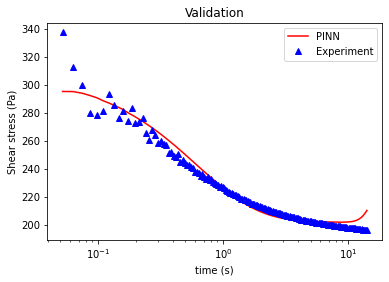

In [56]:
# plotting
plt.plot(t_expt_dp,test_shear_stress_dp, '-r', label='PINN')
plt.plot(t_expt_dp,shear_stress_dp, '^b', label='Experiment')
plt.legend()
plt.xscale('log')
plt.title('Validation')
plt.xlabel('time (s)')
plt.ylabel('Shear stress (Pa)')
plt.show()

In [15]:
print(shear_stress_training)

[[6.60790615]
 [6.56237459]
 [6.5502752 ]
 ...
 [6.85788711]
 [6.85732205]
 [6.85675668]]
